# Aufgabe-D-Schilder

## Allgemeines

Eine allgemeine Beschreibung der Laboraufgaben inklusive des Vorgehens, den Bewertungsrichtlinien und der Abgabe finden Sie  <a href="ML-allgemein.ipynb">hier</a>

## Bearbeiter
**TINF19-IT2**  
Patrick Küsters (9815596)  
Nick Kramer (3122448)  
**TINF19-IT1**  
Sören Holzenkamp (8528927)

## VM zum Trainieren großer Modelle

- Nutzung des Clusters der DHBW
    - wichtige Links
    - VPN-Endpunkt: drogon.dhbw-mannheim.de
    - Anmeldeseite Cluster: https://cloud.4c.dhbw-mannheim.de/
1. Ping external IP (Floating IP)
    1. Not working? --> New Floating IP
    2. Working --> ssh ubuntu@141.72.191.72 -i privatekey.txt

## Datenquelle


* Laden Sie ihre Daten von http://141.72.190.207/ml_lab/D_schilder herunter
    * Die Daten sind geschützt. 
    * Sie müssen evtl. in einem Netzwerk der DHBW (z.B. WLAN, VPN, ...) angemeldet sein. 
        * Sie können sich auf der Webseite mit dem Benutzernamen dhbw und dem Zugangsnamen ml_2021 anmelden. 
    



## Readme der Daten

This archive contains the following structure:

There is one directory for each of the 43 classes (0000 - 00043).
Each directory contains the corresponding training images and one 
text file with annotations, eg. GT-00000.csv. 


**********************************************
Image format and naming  
**********************************************
The images are PPM images (RGB color). Files are numbered in two parts:

   XXXXX_YYYYY.ppm

The first part, XXXXX, represents the track number. All images of one class 
with identical track numbers originate from one single physical traffic sign.
The second part, YYYYY, is a running number within the track. The temporal order
of the images is preserved.


**********************************************
Annotation format
**********************************************

The annotations are stored in CSV format (field separator
is ";" (semicolon) ). The annotations contain meta information 
about the image and the class id.


In detail, the annotations provide the following fields:

Filename        - Image file the following information applies to
Width, Height   - Dimensions of the image
Roi.x1,Roi.y1,
Roi.x2,Roi.y2   - Location of the sign within the image
		  (Images contain a border around the actual sign
                  of 10 percent of the sign size, at least 5 pixel)
ClassId         - The class of the traffic sign


In [1]:
# Dictionary für alle Klassen im Datensatz
# Quelle für meiste Bezeichnungen: https://www.adac.de/verkehr/recht/verkehrszeichen/

classes = { 0:'Geschwindigkeitsbegrenzung (20km/h)',
            1:'Geschwindigkeitsbegrenzung (30km/h)',      
            2:'Geschwindigkeitsbegrenzung (50km/h)',       
            3:'Geschwindigkeitsbegrenzung (60km/h)',      
            4:'Geschwindigkeitsbegrenzung (70km/h)',    
            5:'Geschwindigkeitsbegrenzung (80km/h)',      
            6:'Ende der Geschwindigkeitsbegrenzung (80km/h)',     
            7:'Geschwindigkeitsbegrenzung (100km/h)',    
            8:'Geschwindigkeitsbegrenzung (120km/h)',     
            9:'Überholverbot',   
           10:'Überholverbot >3.5t',     
           11:'Vorfahrt nächste Kreuzung',     
           12:'Vorfahrtsstraße',    
           13:'Vorfahrt gewähren',     
           14:'Stop',       
           15:'Verbot für Fahrzeuge aller Art',       
           16:'Verbot für Fahrzeuge >3.5t',       
           17:'Verbot der Einfahrt',       
           18:'Gefahrenstelle',     
           19:'Kurve (links)',      
           20:'Kurve (rechts)',   
           21:'Doppelkurve',      
           22:'Unebene Fahrbahn',     
           23:'Schleuder-/Rutschgefahr',       
           24:'Einseitig (rechts) verengte Fahrbahn',  
           25:'Arbeitsstelle',    
           26:'Lichtzeichenanlage', # zu deutsch: Ampel      
           27:'Fußgänger',     
           28:'Kinder',     
           29:'Radfahrer',       
           30:'Schnee-/Eisglätte',
           31:'Wildwechsel',      
           32:'Ende sämtlicher Geschw-begr./Überholverb.',      
           33:'Vorgeschriebene Fahrtrichtung rechts',     
           34:'Vorgeschriebene Fahrtrichtung links',       
           35:'Vorgeschriebene Fahrtrichtung gerade',      
           36:'Vorgeschriebene Fahrtrichtung gerade/rechts',      
           37:'Vorgeschriebene Fahrtrichtung gerade/links',      
           38:'Vorgeschriebene Vorbeifahrt rechts vorbei',     
           39:'Vorgeschriebene Vorbeifahrt rechts vorbei',      
           40:'Kreisverkehr',     
           41:'Ende Überholverbot',      
           42:'Ende Überholverbot >3.5t' 
          }

## Aufgabe

* die Daten 
    * enthalten mehr als 50000 Bilder von Verkehrsschilder auf deutschen Straßen
    * pro Klasse der Daten gibt es ein Verzeichnis
    * in jeder Klasse gibt eine CSV-Datei mit Annotationen der Bilder
        * Die Namen lauten GT-<ClassID>.csv
* die Bilder 
    * enthalten genau ein Verkehrszeichen, mit ca. 10% Rand um das Verkehrszeichen
    * sind im PPM Format gespeichert
    * die Größen der Bilder variieren von 15x15 Pixel bis zu 250x250 Pixel
        * die Bilder müssen aber nicht quadratisch sein
    * In den Annotationen ist auch die Bounding Box hinterlegt
* die Annotations-Datei hat den folgenden Werte
    * Dateiname, Width, Height, BB.x1, BB.y1, BB.x2, BB.y2, ClassId
        * BB steht für BoundingBox

Erstellen Sie ein tiefes neuronales Netz, dass Schilder in Bildern erkennt und die Position des erkannten Schilds als Bounding Box ausgibt! Die Lösung soll auch mehrere Schilder in einem Bild erkennen können! 


# Lösung

Implementierung und Dokumentation

## Imports
Lokal entwickelte Skripte und Module

In [2]:
import sys
from pathlib import Path
module_path = str(Path.cwd() / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from reader import Reader
from display_data import ImageDisplayer

Externe Bibliotheken

In [4]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt

Funktion "drawImage" --> BB und Image wird dargestellt, mapping über Namen<br>
Einlesen von Bildern mit zugehörigen Namen

## Einlesen der Daten
Der Datensatz besteht aus 43 Ordnern, welche je eine Klasse abbilden.  
- Beispiel: In Ordner 0 liegen ausschließlich Bilder von Tempo 20 Schildern ab  

### Reader
Reader() stellt eine selbst entwickelte Klasse dar. <a href="./src/reader.py">Sie ist hier zu finden</a>.<br>
Diese iteriert durch alle Ordner und liest die Annotation-Files ein. Diese Informationen werden in einem pandas DataFrame gespeichert.  

In [5]:
reader = Reader()
df = reader.read_data(folders=43, pre_path=r"./data/")
df

,Filename,Folder,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000_00000.ppm,./data/0/,29,30,5,6,24,25,0
1,00000_00001.ppm,./data/0/,30,30,5,5,25,25,0
2,00000_00002.ppm,./data/0/,30,30,5,5,25,25,0
3,00000_00003.ppm,./data/0/,31,31,5,5,26,26,0
4,00000_00004.ppm,./data/0/,30,32,5,6,25,26,0
...,...,...,...,...,...,...,...,...,...
39204,00007_00025.ppm,./data/42/,52,56,5,6,47,51,42
39205,00007_00026.ppm,./data/42/,56,58,5,5,51,53,42
39206,00007_00027.ppm,./data/42/,58,62,5,6,53,57,42
39207,00007_00028.ppm,./data/42/,63,69,5,7,58,63,42


### Beschreibung der Daten
Der Datensatz besteht aus 39209 Einträgen, welcher sich in 43 Klassen unterteilt.  
Jeder Eintrag stellt ein Bild dar, welches eine gewissen Breite und Höhe besitzt. **Die Bilder besitzen also nicht die gleiche Größe.**  
Zudem ist die "Bounding Box" durch die 4 Spalten beginnend mit Roi abgebildet. (X1, Y1) spannt mit (X2, Y2) ein Rechteck auf, in welchem sich das Verkehrszeichen befinden soll.

Zusätzlich wird der Pfad zu der einzelnen Bilder gespeichert. Der Grund hierfür ist die Nicht-Eindeutigkeit der Dateinamen über den eigenen Ordner hinaus.  
Dies geht auch aus dem Readme der Daten hervor (ein Dateiname besteht aus Track und Tracknummer).  

In [6]:
lookup_filename = "00000_00000.ppm"
print("Vorkommnisse von " + lookup_filename + ":")
print(len(df.index[df["Filename"] == lookup_filename]))

print()

lookup_folder_with_filename = r"./data/0/00000_00000.ppm"
print("Vorkommnisse von " + lookup_folder_with_filename + ":")
print(len(df.index[df["Folder"] + df["Filename"] == lookup_folder_with_filename]))

Vorkommnisse von 00000_00000.ppm:
43

Vorkommnisse von ./data/0/00000_00000.ppm:
1


In [7]:
#ImageDisplayer(df, 100, 105)

## Plots zur Veranschaulichung des Datensatzes

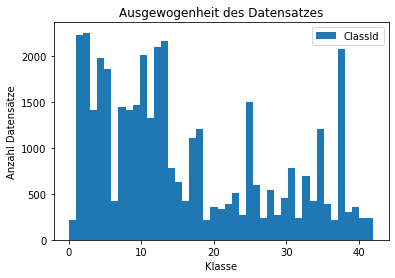

In [8]:
df.plot(y="ClassId", kind="hist", bins=len(set(df["ClassId"])))
plt.title("Ausgewogenheit des Datensatzes")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Klasse")
plt.show()

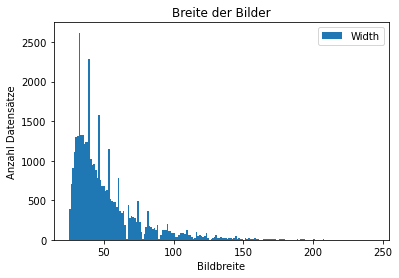

In [9]:
df.plot(y="Width", kind="hist", bins=len(set(df["Width"])))
plt.title("Breite der Bilder")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Bildbreite")
plt.show()

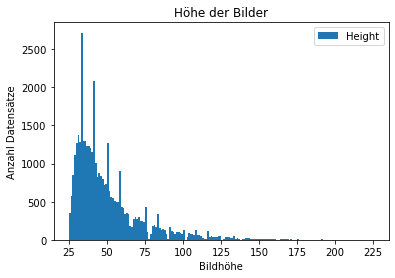

In [10]:
df.plot(y="Height", kind="hist", bins=len(set(df["Height"])))
plt.title("Höhe der Bilder")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Bildhöhe")
plt.show()

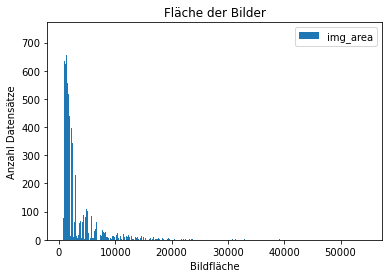

In [11]:
df["img_area"] = df["Width"]*df["Height"]
df.plot(y="img_area", kind="hist", bins=len(set(df["img_area"])))
plt.title("Fläche der Bilder")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Bildfläche")
plt.show()

In [12]:
df["x_box_len"] = df["Roi.X2"] - df["Roi.X1"]
df["y_box_len"] = df["Roi.Y2"] - df["Roi.Y1"]
df["box_area"] = df["x_box_len"]*df["y_box_len"]

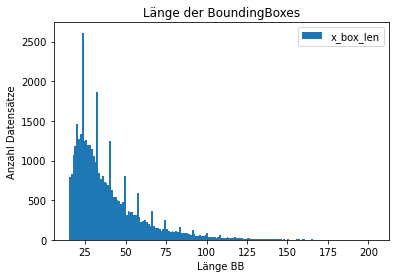

In [13]:
df.plot(y="x_box_len", kind="hist", bins=len(set(df["x_box_len"])))
plt.title("Länge der BoundingBoxes")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Länge BB")
plt.show()

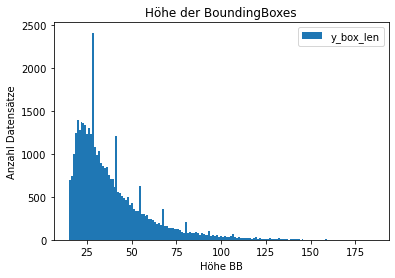

In [14]:
df.plot(y="y_box_len", kind="hist", bins=len(set(df["y_box_len"])))
plt.title("Höhe der BoundingBoxes")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Höhe BB")
plt.show()

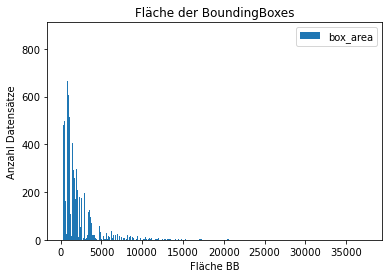

In [15]:
df.plot(y="box_area", kind="hist", bins=len(set(df["box_area"])))
plt.title("Fläche der BoundingBoxes")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Fläche BB")
plt.show()

## Bildklassifizierung
### Vorbereitung

In [16]:
from skimage import exposure
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

#### Darstellung und Überblick
Um ein Gefühl für die Daten zu bekommen, wird eine Collage erstellt, die jedes 500. Bild darstellt.

In [17]:
def create_collage(collage_savepath):
    collage = Image.new("RGBA", (1300, 600))
    x = 0
    y = 0
    for index, row in df.iterrows():
        image = load_img(row["Folder"]+row["Filename"])
        image = image.crop((row["Roi.X1"], row["Roi.Y1"], row["Roi.X2"], row["Roi.Y2"]))
        image = image.resize((100, 100))
        if(index > 0 and index%500 == 0):
            #print(index)
            collage.paste(image, (x,y))
            x+=100
            if(x > 1200):
                x=0
                y+=100
    collage.save(collage_savepath)
    
    
create_collage(r"./images/collage_cropped_images.png")

Es ist auffällig, dass die Qualität der Bilder stark unterschiedlich ist:
- Einige Bilder sind extrem dunkel und besitzen einen geringen Kontrast. 
- Durch das Skalieren der Bilder unterscheidet sich die Auflösung stark.

Teilweise sind Schilder selbst für ein menschliches Auge nicht eindeutig identifizierbar.  
**************
Es sind folgende Gemeinsamkeiten festzustellen:
- Der Bildwinkel ist immer gleich
- Die Schilder sind vollständig abgebildet und besitzen keine "Störungen" (Überdeckungen, Verunreinigungen, ...)

Dies lässt die Frage offen, ob ein späteres Modell Bilder aus dem "echten" Leben erkennen kann.

Im Zuge der Recherche für die Datenvorbereitung fiel ein <a href="https://medium.com/@thomastracey/recognizing-traffic-signs-with-cnns-23a4ac66f7a7">Paper</a> auf, welches ein Verfahren namens "CLAHE" nutzte um einen größeren Kontrast herzustellen.<br>
Beim späteren Trainieren neuronaler Netze kann betrachtet werden, ob dies einen signifikanten Unterschied bei der Leistung des Modells mit sich bringt.

In [18]:
def normalize_image(image, x, y, h, w):
    image = image[y:y+h, x:x+w]
    image = cv2.resize(image,(100, 100))
    image = exposure.equalize_adapthist(image, clip_limit=0.05)
    return image


def create_normalized_collage(collage_savepath):
    line = []
    columns = []
    for index, row in df.iterrows(): 

        image = cv2.imread(row["Folder"]+row["Filename"])
        x = row["Roi.X1"]
        y = row["Roi.Y1"]
        h = row["Roi.Y2"]-row["Roi.Y1"]
        w = row["Roi.X2"]-row["Roi.X1"]

        image = normalize_image(image, x, y, h, w)

        if(index > 0 and index%500 == 0):
            line.append(image)
            if(len(line)==13):
                columns.append(np.hstack(line))
                line = []
    collage = np.vstack(columns)
    collage = cv2.convertScaleAbs(collage, alpha=(255.0))
    cv2.imwrite(collage_savepath, collage)

    
create_normalized_collage(r"./images/collage_cropped_normalized_images.png")

Darstellungen ohne weitere Nachbearbeitung (nur Zuschnitt auf Bounding Box):

<img src="./images/collage_cropped_images.png">

Bilder mit Nachbearbeitung (höherer Kontrast):

<img src="./images/collage_cropped_normalized_images.png">

### CNN / Klassifizierung

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from skimage import transform
from sklearn.model_selection import train_test_split

In [20]:
class TrafficSignNetwork:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # CONV => RELU => BN => POOL
        model.add(Conv2D(8, (5, 5), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # first set of (CONV => RELU => CONV => RELU) * 2 => POOL
        model.add(Conv2D(16, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(16, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # second set of (CONV => RELU => CONV => RELU) * 2 => POOL
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # second set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        # return the constructed network architecture
        return model

In [21]:
data = []
labels = []

for index, row in df.iterrows(): 
    if index>0 and index%5000 == 0:
        print("Iterated through", index, "images")
    elif index+1 == len(df):
        print("Iterated through all images")
        
    image = cv2.imread(row["Folder"]+row["Filename"])
    x = row["Roi.X1"]
    y = row["Roi.Y1"]
    h = row["Roi.Y2"]-row["Roi.Y1"]
    w = row["Roi.X2"]-row["Roi.X1"]
    image = image[y:y+h, x:x+w]
    image = transform.resize(image, (32, 32))   #cv2.resize??
    image = exposure.equalize_adapthist(image, clip_limit=0.1)
    data.append(image)
    labels.append(int(row["ClassId"]))

data = np.array(data)
labels = np.array(labels)

Iterated through 5000 images
Iterated through 10000 images
Iterated through 15000 images
Iterated through 20000 images
Iterated through 25000 images
Iterated through 30000 images
Iterated through 35000 images
Iterated through all images


In [22]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=1234)

In [23]:
cv2.imshow("Image",X_train[0])
k = cv2.waitKey(0)
cv2.destroyAllWindows()

In [24]:
NUM_EPOCHS = 20
INIT_LR = 1e-3
BS = 64

In [25]:
# Skalierung auf [0,1]
X_train = X_train.astype("float32")/255.0
X_test = X_test.astype("float32")/255.0

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

In [26]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
model = TrafficSignNetwork.build(width=32, height=32, depth=3, classes=43)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         608       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        6

In [28]:
H = model.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              epochs = NUM_EPOCHS
            )

Epoch 1/20
919/919 [==============================] - 32s 35ms/step - loss: 1.6466 - accuracy: 0.5586 - val_loss: 0.4049 - val_accuracy: 0.8917
Epoch 2/20
919/919 [==============================] - 31s 34ms/step - loss: 0.4880 - accuracy: 0.8560 - val_loss: 0.1911 - val_accuracy: 0.9443
Epoch 3/20
919/919 [==============================] - 31s 34ms/step - loss: 0.2743 - accuracy: 0.9195 - val_loss: 0.0869 - val_accuracy: 0.9751
Epoch 4/20
919/919 [==============================] - 31s 34ms/step - loss: 0.1905 - accuracy: 0.9438 - val_loss: 0.0755 - val_accuracy: 0.9780
Epoch 5/20
919/919 [==============================] - 31s 34ms/step - loss: 0.1470 - accuracy: 0.9566 - val_loss: 0.0724 - val_accuracy: 0.9775
Epoch 6/20
919/919 [==============================] - 31s 34ms/step - loss: 0.1181 - accuracy: 0.9645 - val_loss: 0.0474 - val_accuracy: 0.9863
Epoch 7/20
919/919 [==============================] - 31s 34ms/step - loss: 0.1009 - accuracy: 0.9686 - val_loss: 0.0437 - val_accuracy:

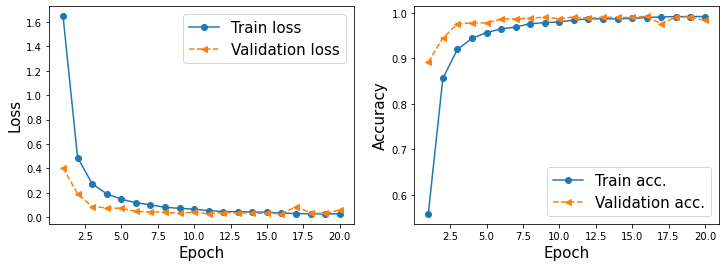

In [29]:
hist = H.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [30]:
model.evaluate(X_test, y_test)

307/307 [==============================] - 3s 8ms/step - loss: 0.0590 - accuracy: 0.9831


[0.05902941897511482, 0.9830663800239563]

In [31]:
preds = model.predict(X_test)
preds = tf.argmax(preds, axis=1)
preds

<tf.Tensor: shape=(9803,), dtype=int64, numpy=array([35, 10, 42, ..., 26, 11,  2], dtype=int64)>

In [32]:
print(classes[preds[0].numpy()])
cv2.imshow("Image",X_test[0]*255)
k = cv2.waitKey(0)
cv2.destroyAllWindows()

Vorgeschriebene Fahrtrichtung gerade


In [33]:
wrong_preds = preds.numpy() !=  tf.argmax(y_test, axis=1).numpy()
wrong_preds_index = np.where(wrong_preds == True)
print("Falsche Vorhersagen:", len(wrong_preds_index[0]), "von:", len(preds.numpy()))

Falsche Vorhersagen: 166 von: 9803


In [34]:
#for i in wrong_predictions_index[0]:
 #   print(classes[real[i].numpy()])
  #  cv2.imshow("Image",X_test[i]*255)
   # k = cv2.waitKey(0)
    #cv2.destroyAllWindows()